In [75]:
import cv2
import numpy as np

# 读取彩色图片
img = cv2.imread("dataset/Blue/9.jpg")

# 转换为灰度图
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 高斯模糊
img_gauss = cv2.GaussianBlur(img_gray, (5, 5), 1.4)

# 用Sobel算子进行边缘检测
img_sobel = cv2.Sobel(img_gauss, cv2.CV_8U, 1, 0, ksize=1)

# Canny边缘检测
img_canny = cv2.Canny(img_sobel, 100, 250)

# 进行二值化处理
i, img_threshold = cv2.threshold(img_canny, 0, 255, cv2.THRESH_BINARY)

# 侵蚀和扩张
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (38, 28))
img_dilate = cv2.dilate(img_threshold, kernel)

# 循环找到所有的轮廓
contours, hierarchy = cv2.findContours(img_dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plates_blue = []
plates_green = []
cnt = 0

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 2.5 * h and w < 4.5 * h:  # 根据车牌的宽高比过滤
        print(1)
        # 裁剪车牌区域
        plate = img[y:y+h, x:x+w]

        # 转换为 HSV 空间
        plate_hsv = cv2.cvtColor(plate, cv2.COLOR_BGR2HSV)

        # 蓝色范围
        blue_lower = np.array([100, 43, 46])
        blue_upper = np.array([124, 255, 255])

        # 绿色范围
        green_lower = np.array([35, 43, 46])
        green_upper = np.array([77, 255, 255])

        # 创建掩码
        blue_mask = cv2.inRange(plate_hsv, blue_lower, blue_upper)
        green_mask = cv2.inRange(plate_hsv, green_lower, green_upper)

        # 计算蓝色和绿色像素的比例
        blue_ratio = np.sum(blue_mask > 0) / (plate.shape[0] * plate.shape[1])
        green_ratio = np.sum(green_mask > 0) / (plate.shape[0] * plate.shape[1])

        # 判断是否为蓝色或绿色车牌
        if blue_ratio > 0.2:
            print(f"找到蓝色车牌区域，车牌编号为 {cnt + 1}")
            cv2.imshow(f"Blue Plate {cnt + 1}", plate)
            plates_blue.append(plate)
            cnt += 1
        elif green_ratio > 0.2:
            print(f"找到绿色车牌区域，车牌编号为 {cnt + 1}")
            cv2.imshow(f"Green Plate {cnt + 1}", plate)
            plates_green.append(plate)
            cnt += 1

if not cnt:
    print("未找到车牌，请检查输入图片！")
else:
    print(f"找到 {cnt} 个可能的蓝色或绿色车牌。")

cv2.waitKey(0)
cv2.destroyAllWindows()

未找到车牌，请检查输入图片！


C:\Users\lenovo\AppData\Local\Temp\ipykernel_50324\1859068989.py:54: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


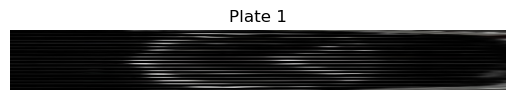

In [74]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    # 读取彩色的图片
    img = cv.imread(image_path)
    if img is None:
        print("图片加载失败，请检查路径")
        return None, None

    # 转换为灰度图
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # 高斯模糊
    img_gauss = cv.GaussianBlur(img_gray, (5, 5), 1.4)

    return img, img_gauss

def detect_edges(img_gauss):
    # 用 Sobel 算子进行边缘检测
    img_sobel = cv.Sobel(img_gauss, cv.CV_8U, 1, 0, ksize=1)

    # Canny 边缘检测
    img_canny = cv.Canny(img_sobel, 100, 250)

    # 二值化处理
    _, img_threshold = cv.threshold(img_canny, 0, 255, cv.THRESH_BINARY)

    return img_threshold

def process_morphology(img_threshold):
    # 侵蚀和扩张
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (43, 33))
    img_dilate = cv.dilate(img_threshold, kernel)

    return img_dilate

def find_license_plates(img, img_dilate):
    # 循环找到所有的轮廓
    contours, _ = cv.findContours(img_dilate, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    plates = []

    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)

        # 筛选长宽比符合车牌特征的区域
        if w > 2 * h:
            plate = img[y:y + h, x:x + w]

            # 仿射变换矫正车牌区域
            rect = cv.minAreaRect(contour)
            box = cv.boxPoints(rect)
            box = np.int0(box)

            width, height = int(rect[1][0]), int(rect[1][1])
            if width < height:
                width, height = height, width

            src_pts = box.astype("float32")
            dst_pts = np.array([[0, height - 1], [0, 0], [width - 1, 0], [width - 1, height - 1]], dtype="float32")
            M = cv.getPerspectiveTransform(src_pts, dst_pts)
            plate = cv.warpPerspective(img, M, (width, height))

            plates.append(plate)

    return plates

def display_plates(plates):
    for i, plate in enumerate(plates):
        plt.figure()
        plt.title(f"Plate {i + 1}")
        plt.imshow(cv.cvtColor(plate, cv.COLOR_BGR2RGB))
        plt.axis("off")
    plt.show()

def main(image_path):
    # 图像预处理
    img, img_gauss = preprocess_image(image_path)
    if img is None:
        return

    # 边缘检测
    img_threshold = detect_edges(img_gauss)

    # 形态学处理
    img_dilate = process_morphology(img_threshold)

    # 查找车牌区域
    plates = find_license_plates(img, img_dilate)

    # 显示结果
    display_plates(plates)

# 测试代码
if __name__ == "__main__":
    image_path = "dataset/Blue/9.jpg"
    main(image_path)


In [69]:
import cv2
import matplotlib.pyplot as plt

# 读取彩色的图片
img = cv2.imread("dataset/Blue/11.jpg")

# 转换为灰度图
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 高斯模糊
img_gauss = cv2.GaussianBlur(img_gray, (5, 5), 1.4)

# 用Sobel算子进行边缘检测
img_sobel = cv2.Sobel(img_gauss, cv2.CV_8U, 1, 0, ksize=1)

# Canny边缘检测
img_canny = cv2.Canny(img_sobel, 100, 250)

# 进行二值化处理
i, img_threshold = cv2.threshold(img_canny, 0, 255, cv2.THRESH_BINARY)

# 侵蚀和扩张
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (43, 33))
img_dilate = cv2.dilate(img_threshold, kernel)

# 循环找到所有的轮廓
contours, hierarchy = cv2.findContours(img_dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
results = []
cnt = 0

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 2.5 * h and w < 4.5 * h:
        cnt += 1
        results.append(img[y:y+h, x:x+w])
        cv2.imshow(f"Plate {cnt}", img[y:y+h, x:x+w])

if not cnt:
    print("未找到车牌，请检查输入图片！")
else:
    print(f"找到 {cnt} 个可能的车牌。")

cv2.waitKey(0)
cv2.destroyAllWindows() 

找到 3 个可能的车牌。
